# Adult and fetal unsupervised integration

Testing against "supervised" scArches integration

In [1]:
import sys,os
import scvi
import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import scipy

import torch
device = torch.device("cuda")

Global seed set to 0


In [2]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [3]:
cwd = '../utils/'
sys.path.append(cwd)
import genes
import panfetal_utils

scVI integration utils (see `Pan_fetal_immune/src/02_integration_scRNA/integration_scRNA_run_scVI_subsets_v2.py`)

In [4]:
def subset_top_hvgs(adata_lognorm, n_top_genes):
    dispersion_norm = adata_lognorm.var['dispersions_norm'].values.astype('float32')

    dispersion_norm = dispersion_norm[~np.isnan(dispersion_norm)]
    dispersion_norm[
                ::-1
            ].sort()  # interestingly, np.argpartition is slightly slower

    disp_cut_off = dispersion_norm[n_top_genes - 1]
    gene_subset = adata_lognorm.var['dispersions_norm'].values >= disp_cut_off
    return(adata_lognorm[:,gene_subset])

def prep_scVI(adata, 
              n_hvgs = 5000,
              remove_cc_genes = True,
              remove_tcr_bcr_genes = False
             ):
    ## Remove cell cycle genes
    if remove_cc_genes:
        adata = panfetal_utils.remove_geneset(adata,genes.cc_genes)

    ## Remove TCR/BCR genes
    if remove_tcr_bcr_genes:
        adata = panfetal_utils.remove_geneset(adata, genes.IG_genes)
        adata = panfetal_utils.remove_geneset(adata, genes.TCR_genes)
        
    ## HVG selection
    adata = subset_top_hvgs(adata, n_top_genes=n_hvgs)
    
    ## Change gene names to ids
    adata.var_names = adata.var['GeneID'].values.copy()
    return(adata)

def train_scVI(adata, n_dims=20):
    adata = scvi.model.SCVI.setup_anndata(adata, 
                                    categorical_covariate_keys = ["method", 'donor'], 
                                    copy=True)
    ## updated in new scArches version
    arches_params = dict(
        use_layer_norm="both",
        use_batch_norm="none",
        encode_covariates=True,
        dropout_rate=0.2,
        n_layers=2,
    )
    vae = scvi.model.SCVI(adata, n_latent=n_dims, **arches_params)
    vae.train(early_stopping=True,
        train_size=0.9,
        early_stopping_patience=45,
        max_epochs=400, 
        batch_size=1024, 
        limit_train_batches=20
       )
    return(vae)

In [ ]:
adata = adata[:,~adata.var_names.isin(list(geneset))].copy()

---

## Lymphoid cells

### Read and merge datasets

In [140]:
ref_data_dir = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'
query_h5ad_file = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/panimmune_full_LYMPHOID_query.h5ad'
split = 'LYMPHOID_NEW'

In [141]:
query_adata_full = sc.read_h5ad(query_h5ad_file)

In [7]:
## Read reference
ref_adata = sc.read_h5ad(ref_data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
ref_adata.var_names = ref_adata.var.GeneID

## Merge
concat_adata = anndata.concat([ref_adata, query_adata_full], axis=0,
                              label="dataset", keys=["fetal", "adult"],
                              join="outer", merge="unique", uns_merge="unique")
concat_adata.obs_names = concat_adata.obs_names + "-" + concat_adata.obs["dataset"].astype("str")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [8]:
## Restrict to common genes
concat_adata = concat_adata[:,concat_adata.var['GeneID'] == concat_adata.var['gene_ids']].copy()

### Load metadata for fetal cells

In [9]:
anno_obs = pd.read_csv(ref_data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

/opt/conda/envs/ed6/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [43]:
fetal_cell_ixs = concat_adata.obs_names[concat_adata.obs['dataset'] == 'fetal'].str.strip('-fetal')
fetal_cell_ixs = fetal_cell_ixs[fetal_cell_ixs.isin(anno_obs.index)] # There is a small number of missing cells (42 cells) from anno_obs and I don't know why??

concat_adata.obs['organ'] = np.nan
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'organ'] = anno_obs.loc[fetal_cell_ixs, 'organ'].astype('str').values
concat_adata.obs['gestational_age'] = np.nan
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'gestational_age'] = anno_obs.loc[fetal_cell_ixs, 'age'].astype('int').values
concat_adata.obs['annotation_fetal'] = np.nan
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'annotation_fetal'] = anno_obs.loc[fetal_cell_ixs, 'anno_lvl_2_final_clean'].astype('str').values

## Add common metadata (covs used for integration)
concat_adata.obs['donor'] = concat_adata.obs['donor'].astype("str")
concat_adata.obs['method'] = concat_adata.obs['method'].astype("str")
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'donor'] = anno_obs.loc[fetal_cell_ixs, 'donor'].astype('str').values
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'method'] = anno_obs.loc[fetal_cell_ixs, 'method'].astype('str').values
concat_adata = concat_adata[concat_adata.obs['donor']!='nan'].copy()

### Feature selection

In [44]:
concat_adata_pp = concat_adata.copy()

In [45]:
## Save dispersion estimates for HVG selection
concat_adata_pp.var_names_make_unique()
sc.pp.normalize_per_cell(concat_adata_pp, counts_per_cell_after=10e4)
sc.pp.log1p(concat_adata_pp)
sc.pp.highly_variable_genes(concat_adata_pp, min_mean=0.001, max_mean=10, subset=False)
concat_adata_pp.var

,GeneID,GeneName,gene_names,highly_variable,gene_ids,feature_types,means,dispersions,dispersions_norm
ENSG00000000003,ENSG00000000003,TSPAN6,TSPAN6,False,ENSG00000000003,Gene Expression,2.357552e-01,3.227234,-0.133530
ENSG00000000005,ENSG00000000005,TNMD,TNMD,False,ENSG00000000005,Gene Expression,6.632406e-04,3.172269,-0.228967
ENSG00000000419,ENSG00000000419,DPM1,DPM1,False,ENSG00000000419,Gene Expression,1.527216e+00,3.122139,-0.421326
ENSG00000000457,ENSG00000000457,SCYL3,SCYL3,False,ENSG00000000457,Gene Expression,7.907402e-01,3.261065,-0.201772
ENSG00000000460,ENSG00000000460,C1orf112,C1orf112,False,ENSG00000000460,Gene Expression,6.091862e-01,3.221283,-0.255356
...,...,...,...,...,...,...,...,...,...
ENSG00000282851,ENSG00000282851,BISPR,BISPR,False,ENSG00000282851,Gene Expression,8.704207e-01,3.307917,-0.092907
ENSG00000282939,ENSG00000282939,TRBV7-2,TRBV7-2,True,ENSG00000282939,Gene Expression,1.785387e+00,6.265013,3.478871
ENSG00000282961,ENSG00000282961,PRNCR1,PRNCR1,False,ENSG00000282961,Gene Expression,2.188461e-01,3.242173,-0.107590
ENSG00000283039,ENSG00000283039,KLF18,KLF18,False,ENSG00000283039,Gene Expression,1.000000e-12,NaN,0.000000


In [46]:
concat_adata.var = concat_adata_pp.var.copy()

In [47]:
concat_adata.write_h5ad(ref_data_dir + 'merged_fetal_adult.LYMPHOID_NEW.h5ad')

/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'method' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will al

In [69]:
concat_adata = sc.read_h5ad(ref_data_dir + 'merged_fetal_adult.LYMPHOID_NEW.h5ad')

In [70]:
concat_adata = prep_scVI(concat_adata, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)

In [49]:
concat_adata.write_h5ad(ref_data_dir + 'merged_fetal_adult.LYMPHOID_NEW.4scvi.h5ad')

In [50]:
# concat_adata = sc.read_h5ad(ref_data_dir + 'merged_fetal_adult.LYMPHOID.4scvi.h5ad')

### Run scVI integration

In [71]:
vae = train_scVI(concat_adata, n_dims=20)
concat_adata.obsm["X_scVI"] = vae.get_latent_representation()

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 504242 cells, 7500 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [14:56<00:00,  2.24s/it, loss=1.17e+03, v_num=1]


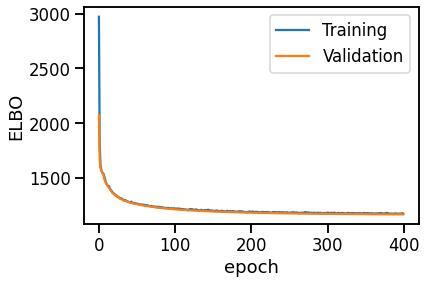

In [72]:
## Plot convergence
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");
# plt.savefig("{f}/scvi_training_elbo_{s}.pdf".format(s=s, f=figdir), bbox_inches="tight")

In [91]:
split='LYMPHOID_NEW'

In [92]:
## Save object
outname = "merged_fetal_adult.{s}.scVI_out.npy".format(s=split)
np.save(ref_data_dir + outname, concat_adata.obsm["X_scVI"])

# save the model
model_dir = 'scvi_merged_fetal_adult_{s}_model/'.format(s=split)
if not os.path.exists(ref_data_dir + model_dir):
    os.mkdir(ref_data_dir + model_dir)
vae.save(ref_data_dir + model_dir, overwrite=True)

In [75]:
scvi_outs_dir = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/'
model_dir = 'scvi_LYMPHOID_NEW_model/'
var_names_model = torch.load(scvi_outs_dir + model_dir + 'model.pt')['var_names']

In [93]:
model_dir = 'scvi_merged_fetal_adult_{s}_model/'.format(s="LYMPHOID_NEW")
var_names_model_denovo = torch.load(scvi_outs_dir + model_dir + 'model.pt')['var_names']

In [102]:
np.intersect1d(var_names_model, var_names_model_denovo)

(4074,)

In [131]:
n_zeros = (concat_adata_pp[:,[x in var_names_model_denovo for x in concat_adata_pp.var_names]].X != 0).sum(1)

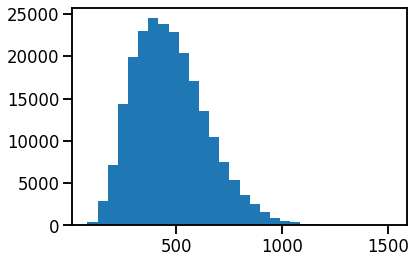

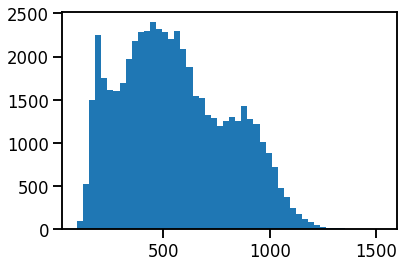

In [132]:
plt.hist(np.array(n_zeros[concat_adata_pp.obs['dataset']=='fetal']).ravel(), bins=30);
plt.show();
plt.hist(np.array(n_zeros[concat_adata_pp.obs['dataset']=='adult']).ravel(), bins=50);

### scVI integration of adult alone

In [ ]:
## Feature selection

In [142]:
query_adata_full_pp = query_adata_full.copy()

## Save dispersion estimates for HVG selection
query_adata_full_pp.var_names_make_unique()
sc.pp.normalize_per_cell(query_adata_full_pp, counts_per_cell_after=10e4)
sc.pp.log1p(query_adata_full_pp)
sc.pp.highly_variable_genes(query_adata_full_pp, min_mean=0.001, max_mean=10, subset=False)

query_adata_full.var = query_adata_full_pp.var.copy()

In [144]:
query_adata_full.var['GeneID'] = query_adata_full.var['gene_ids'].copy()

In [145]:
query_adata_full = prep_scVI(query_adata_full, n_hvgs=7500, remove_cc_genes=True, remove_tcr_bcr_genes=True)

In [146]:
vae = train_scVI(query_adata_full, n_dims=20)
query_adata_full.obsm["X_scVI"] = vae.get_latent_representation()

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 264929 cells, 7500 vars, 1        
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [10:59<00:00,  1.65s/it, loss=996, v_num=1]     


In [150]:
## Save object
outname = "panimmune_full.LYMPHOID.scVI_out.npy"
np.save(ref_data_dir + outname, query_adata_full.obsm["X_scVI"])

# save the model
model_dir = 'panimmune_full_LYMPHOID_model/'
if not os.path.exists(ref_data_dir + model_dir):
    os.mkdir(ref_data_dir + model_dir)
vae.save(ref_data_dir + model_dir, overwrite=True)

In [151]:
scvi_outs_dir = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/'

model_dir = 'scvi_LYMPHOID_NEW_model/'
var_names_model_fetal = torch.load(scvi_outs_dir + model_dir + 'model.pt')['var_names']

model_dir = 'scvi_merged_fetal_adult_{s}_model/'.format(s="LYMPHOID_NEW")
var_names_model_denovo = torch.load(scvi_outs_dir + model_dir + 'model.pt')['var_names']

model_dir = 'panimmune_full_LYMPHOID_model/'
var_names_model_adult = torch.load(scvi_outs_dir + model_dir + 'model.pt')['var_names']

In [164]:
concat_adata.var.loc[var_names_model_adult[pd.Series(var_names_model_adult).isin(concat_adata.var_names)]]
concat_adata.var.loc[var_names_model_fetal[pd.Series(var_names_model_fetal).isin(concat_adata.var_names)]]

,GeneID,GeneName,gene_names,highly_variable,gene_ids,feature_types,means,dispersions,dispersions_norm
ENSG00000000938,ENSG00000000938,FGR,FGR,True,ENSG00000000938,Gene Expression,1.429890,3.810320,0.647272
ENSG00000002586,ENSG00000002586,CD99,CD99,False,ENSG00000002586,Gene Expression,4.145276,5.239363,0.251993
ENSG00000002587,ENSG00000002587,HS3ST1,HS3ST1,True,ENSG00000002587,Gene Expression,0.766446,3.784439,0.503183
ENSG00000002745,ENSG00000002745,WNT16,WNT16,True,ENSG00000002745,Gene Expression,0.102417,3.613536,0.537218
ENSG00000002933,ENSG00000002933,TMEM176A,TMEM176A,False,ENSG00000002933,Gene Expression,0.063593,3.447697,0.249267
...,...,...,...,...,...,...,...,...,...
ENSG00000282320,ENSG00000282320,TRBJ1-1,TRBJ1-1,False,ENSG00000282320,Gene Expression,0.003801,3.457771,0.266759
ENSG00000282499,ENSG00000282499,TRBV25-1,TRBV25-1,True,ENSG00000282499,Gene Expression,0.471030,5.620845,2.976718
ENSG00000282815,ENSG00000282815,TEX13C,TEX13C,False,ENSG00000282815,Gene Expression,0.000142,3.678969,0.650832
ENSG00000282939,ENSG00000282939,TRBV7-2,TRBV7-2,True,ENSG00000282939,Gene Expression,1.785387,6.265013,3.478871


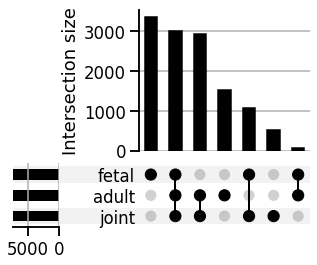

In [188]:
import upsetplot
from upsetplot import plot
from matplotlib import pyplot


example = upsetplot.from_contents({
    'joint':var_names_model_denovo, 
    'fetal':var_names_model_fetal,
    'adult':var_names_model_adult
})

plot(example, sort_by='cardinality');

In [224]:
ref_adata.var.loc[var_names_model_fetal][ref_adata.var.loc[var_names_model_fetal]['GeneName'].str.startswith('TR')]

,GeneID,GeneName
GeneID,,
ENSG00000056558,ENSG00000056558,TRAF1
ENSG00000071575,ENSG00000071575,TRIB2
ENSG00000072657,ENSG00000072657,TRHDE
ENSG00000095970,ENSG00000095970,TREM2
ENSG00000104321,ENSG00000104321,TRPA1
...,...,...
ENSG00000282173,ENSG00000282173,TRBJ1-5
ENSG00000282320,ENSG00000282320,TRBJ1-1
ENSG00000282499,ENSG00000282499,TRBV25-1


In [216]:
query_adata_full[:, adult_specific].var['gene_names'][query_adata_full[:, adult_specific].var['gene_names'].str.startswith("IG")]

ENSG00000163395           IGFN1
ENSG00000211596           IGKJ2
ENSG00000271402      IGKV2OR2-2
ENSG00000271015     IGKV2OR2-7D
ENSG00000270450      IGKV2OR2-7
ENSG00000278537      IGKV2OR2-8
ENSG00000253412    IGHVIII-13-1
ENSG00000253367    IGHVIII-25-1
ENSG00000253482     IGHVII-26-2
ENSG00000254289        IGHV3-32
ENSG00000253491     IGHVII-30-1
ENSG00000270474        IGHV3-29
ENSG00000253359        IGHV3-37
ENSG00000253989    IGHVIII-38-1
ENSG00000253862    IGHVIII-47-1
ENSG00000253386     IGHVII-49-1
ENSG00000254167    IGHVIII-51-1
ENSG00000253941     IGHVII-51-2
ENSG00000253759        IGHV3-57
ENSG00000253674     IGHVII-78-1
ENSG00000188624           IGFL3
ENSG00000253889        IGLVI-38
ENSG00000253963         IGLV3-2
ENSG00000271138    IGLVIVOR22-1
Name: gene_names, dtype: object

In [210]:
intersect_df = example.reset_index()
fetal_specific = intersect_df[(~intersect_df['joint']) & (~intersect_df['adult']) & intersect_df['fetal']]['id']
adult_specific = intersect_df[(~intersect_df['joint']) & (intersect_df['adult']) & (~intersect_df['fetal'])]['id']
np.random.choice(ref_adata[:, fetal_specific].var['GeneName'], 100)

array(['AC020911.1', 'AC018638.7', 'AP001825.1', 'AJ003147.1',
       'AP000753.2', 'AL357793.1', 'LINC02271', 'LINC01990', 'AC005580.1',
       'MAD1L1', 'ZNF396', 'AC020978.5', 'AC241644.3', 'SYDE2', 'GK3P',
       'AC080129.2', 'LINC01855', 'AC135068.9', 'HEY2', 'AL160408.4',
       'AL133387.2', 'HSPB9', 'AC124784.1', 'AC010327.4', 'AL157838.1',
       'ROBO1', 'SOX3', 'AC091100.1', 'TRIM39-RPP21', 'AP001830.1',
       'ZNF436', 'PRDM12', 'GNG14', 'AC013726.1', 'SULF1', 'AC073591.1',
       'AP003392.6', 'AC005329.3', 'AL591503.1', 'AP000759.1',
       'AL353622.2', 'LINC00924', 'RARRES3', 'AC017104.3', 'AC104984.3',
       'AL021807.1', 'LINC02365', 'AC018754.1', 'AL122125.1',
       'AC110615.1', 'SHC4', 'LINC01865', 'AL353801.2', 'LMOD1',
       'AL355916.2', 'AL008718.2', 'AC055874.1', 'AC008676.1',
       'AL391117.1', 'AL512770.1', 'AL121974.1', 'C3AR1', 'AC008514.1',
       'AL139280.1', 'AC005387.1', 'AL022310.1', 'AC016705.2', 'GRIN2C',
       'AC006547.3', 'AC023906.4', '

---

## Myeloid cells

### Read and merge datasets

In [54]:
ref_data_dir = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/'
timestamp = '20210429'
query_h5ad_file = '/home/jupyter/mount/gdrive/Pan_fetal/data4gpu_node/panimmune_full_MYELOID_query.h5ad'
split = 'MYELOID_NEW'

In [55]:
query_adata_full = sc.read_h5ad(query_h5ad_file)

In [56]:
## Read reference
ref_adata = sc.read_h5ad(ref_data_dir + 'PAN.A01.v01.entire_data_raw_count.{t}.{s}.h5ad'.format(t=timestamp, s=split))
ref_adata.var_names = ref_adata.var.GeneID

## Merge
concat_adata = anndata.concat([ref_adata, query_adata_full], axis=0,
                              label="dataset", keys=["fetal", "adult"],
                              join="outer", merge="unique", uns_merge="unique")
concat_adata.obs_names = concat_adata.obs_names + "-" + concat_adata.obs["dataset"].astype("str")

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [57]:
## Restrict to common genes
concat_adata = concat_adata[:,concat_adata.var['GeneID'] == concat_adata.var['gene_ids']].copy()

## Load metadata for fetal cells

In [58]:
anno_obs = pd.read_csv(ref_data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)

/opt/conda/envs/ed6/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [59]:
fetal_cell_ixs = concat_adata.obs_names[concat_adata.obs['dataset'] == 'fetal'].str.strip('-fetal')
fetal_cell_ixs = fetal_cell_ixs[fetal_cell_ixs.isin(anno_obs.index)] # There is a small number of missing cells (42 cells) from anno_obs and I don't know why??

concat_adata.obs['organ'] = np.nan
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'organ'] = anno_obs.loc[fetal_cell_ixs, 'organ'].astype('str').values
concat_adata.obs['gestational_age'] = np.nan
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'gestational_age'] = anno_obs.loc[fetal_cell_ixs, 'age'].astype('int').values
concat_adata.obs['annotation_fetal'] = np.nan
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'annotation_fetal'] = anno_obs.loc[fetal_cell_ixs, 'anno_lvl_2_final_clean'].astype('str').values

## Add common metadata (covs used for integration)
concat_adata.obs['donor'] = concat_adata.obs['donor'].astype("str")
concat_adata.obs['method'] = concat_adata.obs['method'].astype("str")
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'donor'] = anno_obs.loc[fetal_cell_ixs, 'donor'].astype('str').values
concat_adata.obs.loc[fetal_cell_ixs+'-fetal', 'method'] = anno_obs.loc[fetal_cell_ixs, 'method'].astype('str').values
concat_adata = concat_adata[concat_adata.obs['donor']!='nan'].copy()

## Feature selection

In [60]:
concat_adata_pp = concat_adata.copy()

In [61]:
## Save dispersion estimates for HVG selection
concat_adata_pp.var_names_make_unique()
sc.pp.normalize_per_cell(concat_adata_pp, counts_per_cell_after=10e4)
sc.pp.log1p(concat_adata_pp)
sc.pp.highly_variable_genes(concat_adata_pp, min_mean=0.001, max_mean=10, subset=False)
concat_adata_pp.var

,GeneID,GeneName,gene_names,highly_variable,gene_ids,feature_types,means,dispersions,dispersions_norm
ENSG00000000003,ENSG00000000003,TSPAN6,TSPAN6,False,ENSG00000000003,Gene Expression,0.467662,2.829521,-0.481834
ENSG00000000005,ENSG00000000005,TNMD,TNMD,True,ENSG00000000005,Gene Expression,0.022991,3.384258,0.646807
ENSG00000000419,ENSG00000000419,DPM1,DPM1,False,ENSG00000000419,Gene Expression,1.479210,2.831757,-0.658613
ENSG00000000457,ENSG00000000457,SCYL3,SCYL3,False,ENSG00000000457,Gene Expression,0.422044,2.882859,-0.361363
ENSG00000000460,ENSG00000000460,C1orf112,C1orf112,False,ENSG00000000460,Gene Expression,0.453066,2.842742,-0.451971
...,...,...,...,...,...,...,...,...,...
ENSG00000282851,ENSG00000282851,BISPR,BISPR,False,ENSG00000282851,Gene Expression,0.613299,2.989673,-0.120112
ENSG00000282939,ENSG00000282939,TRBV7-2,TRBV7-2,True,ENSG00000282939,Gene Expression,0.045658,5.255836,3.730287
ENSG00000282961,ENSG00000282961,PRNCR1,PRNCR1,False,ENSG00000282961,Gene Expression,0.115570,2.921760,-0.115173
ENSG00000283039,ENSG00000283039,KLF18,KLF18,False,ENSG00000283039,Gene Expression,0.000030,2.124606,-1.428508


In [62]:
concat_adata.var = concat_adata_pp.var.copy()

In [63]:
concat_adata.write_h5ad(ref_data_dir + 'merged_fetal_adult.MYELOID_NEW.h5ad')

/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'donor' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'method' as categorical
/opt/conda/envs/ed6/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will al

In [64]:
concat_adata = prep_scVI(concat_adata, n_hvgs=10000, remove_cc_genes=True, remove_tcr_bcr_genes=True)

In [65]:
concat_adata.write_h5ad(ref_data_dir + 'merged_fetal_adult.MYELOID_NEW.4scvi.h5ad')

In [ ]:
# concat_adata = sc.read_h5ad(ref_data_dir + 'merged_fetal_adult.LYMPHOID.4scvi.h5ad')

## Run scVI integration

In [66]:
vae = train_scVI(concat_adata, n_dims=20)
concat_adata.obsm["X_scVI"] = vae.get_latent_representation()

INFO     No batch_key inputted, assuming all cells are same batch                            
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 276851 cells, 10000 vars, 1       
         batches, 1 labels, and 0 proteins. Also registered 2 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [18:05<00:00,  2.71s/it, loss=2.16e+03, v_num=1]


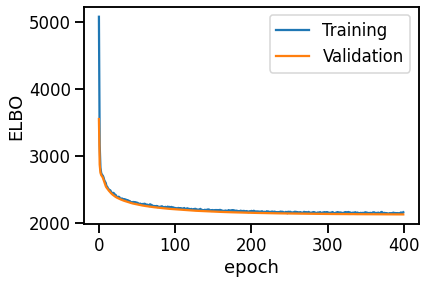

In [67]:
## Plot convergence
sns.set_context("talk")
plt.plot(vae.history["elbo_train"], label="Training");
plt.plot(vae.history["elbo_validation"], label="Validation");
plt.legend();
plt.xlabel("epoch");
plt.ylabel("ELBO");
# plt.savefig("{f}/scvi_training_elbo_{s}.pdf".format(s=s, f=figdir), bbox_inches="tight")

In [68]:
## Save object
outname = "merged_fetal_adult.{s}.scVI_out.npy".format(s=split)
np.save(ref_data_dir + outname, concat_adata.obsm["X_scVI"])

# save the model
model_dir = 'scvi_merged_fetal_adult_{s}_model/'.format(s=split)
if not os.path.exists(ref_data_dir + model_dir):
    os.mkdir(ref_data_dir + model_dir)
vae.save(ref_data_dir + model_dir, overwrite=True)